In [1]:
import numpy as np

from robust_smc.data import ExplosiveTANSimulator, dem
from robust_smc.sampler import LinearGaussianBPF, RobustifiedLinearGaussianBPF

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Matplotlib settings
from cycler import cycler
import matplotlib as mpl

palette = cycler(color=mpl.cm.Set1.colors)
mpl.rc('axes', prop_cycle=palette)
mpl.rc('lines', lw=2)
mpl.rc('axes', lw=1.2, titlesize='x-large', labelsize='x-large')
mpl.rc('legend', fontsize='x-large')

In [3]:
time = 200
time_step = 0.1
observation_std = 20.0
time_axis = np.arange(0, time + 1e-9, time_step)

seed = 1992
# sampler_seed = np.random.randint(0, 1000000)
sampler_seed = 980099

num_samples = 10000

contamination_probability = 0.1
degrees_of_freedom = 1.

In [4]:
process_std = None
simulator = ExplosiveTANSimulator(time, time_step=time_step, contamination_probability=contamination_probability,
                                  observation_std=observation_std, process_std=process_std,
                                  degrees_of_freedom=degrees_of_freedom, seed=seed)

In [5]:
transition_matrix = simulator.transition_matrix
transition_cov = np.diag(simulator.process_std ** 2)
observation_cov = (simulator.observation_std ** 2)

In [6]:
prior_std = np.array([1e-1, 1e-1, 1.0, 1e-2, 1e-2, 1e-1])
X_init = simulator.X0[None, :] + prior_std[None, :] * np.random.randn(num_samples, 6)
X_init = X_init.squeeze()

In [7]:
xx = np.linspace(-10000, 13000, 5000)
yy = np.linspace(-10000, 6000, 5000)
X, Y = np.meshgrid(xx, yy)

In [8]:
vanilla_bpf = LinearGaussianBPF(
    data=simulator.Y,
    transition_matrix=transition_matrix, 
    transition_cov=transition_cov, 
    X_init=X_init, 
    observation_model=simulator.observation_model,
    num_samples=num_samples,
    observation_cov=observation_cov,
    seed=sampler_seed,
)
vanilla_bpf.sample()

In [9]:
robust_bpf = RobustifiedLinearGaussianBPF(
    beta=0.1,
    data=simulator.Y,
    transition_matrix=transition_matrix, 
    transition_cov=transition_cov, 
    X_init=X_init, 
    observation_model=simulator.observation_model,
    num_samples=num_samples,
    observation_cov=observation_cov,
    seed=sampler_seed
)
robust_bpf.sample()

In [10]:
vanilla_trajectories = np.stack(vanilla_bpf.X_trajectories)
robust_trajectories = np.stack(robust_bpf.X_trajectories)
###################################################################
outlier_locations = simulator.contamination_locations[:, 0]
outlier_states = simulator.X[outlier_locations, :]
outlier_observations = simulator.observation_model(outlier_states)
outliers = simulator.Y[outlier_locations]
distance = ((outlier_observations - outliers) ** 2).sum(axis=-1)
biggest_outliers = outlier_locations[np.argsort(distance)[-20:]]

## Terrain Plots

In [11]:
def plot_terrain(ax, state_sequence, title):
    if title == 'BPF':
        cmp = 'Blues'
    else:
        cmp = 'Reds'
    Z = dem(X.flatten()[:, None], Y.flatten()[:, None], num_frequencies=6)
    Z = Z.reshape(5000, 5000)
    levels = np.arange(-1000, 1001, 250)
    cs = ax.contourf(X, Y, Z, levels=levels, cmap='cividis')
    ax.contour(cs, colors='k', alpha=0.8)
    for i in range(100):
        ax.scatter(state_sequence[1:, i, 0], state_sequence[1:, i, 1], 
                    c=np.arange(0, time, time_step), cmap=cmp, label='Predicted', zorder=500)
    ax.scatter(simulator.X[1:, 0], simulator.X[1:, 1], c=np.arange(0, time, time_step),
                cmap='binary', label='True Sequence', marker='.', s=20, zorder=1000)
    ax.set_title(title, fontsize='xx-large')

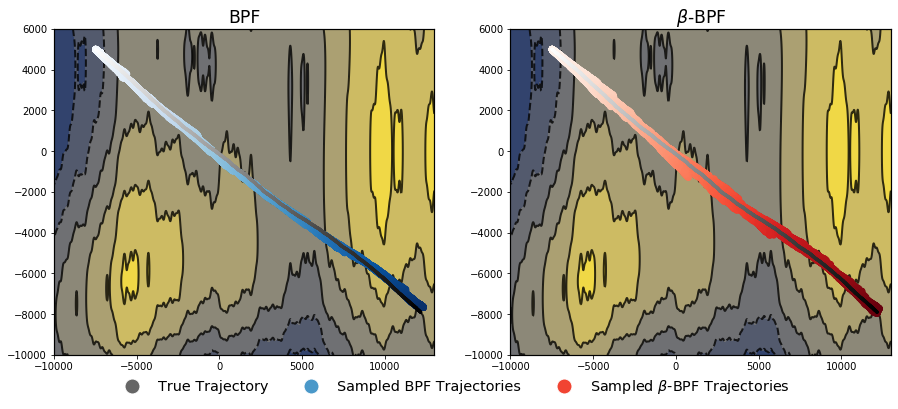

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax = ax.flatten()
plot_terrain(ax[0], vanilla_trajectories, 'BPF')
plot_terrain(ax[1], robust_trajectories, r'$\beta$-BPF')
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.binary(0.6), label='True Trajectory', markersize=15),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Blues(0.6), label='Sampled BPF Trajectories', markersize=15),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Reds(0.6), label=r'Sampled $\beta$-BPF Trajectories', markersize=15)]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.42, 0), fontsize='x-large', frameon=False)

plt.savefig('./figures/paper_figures/tan/terrain_plots.pdf', bbox_inches='tight')

## Latent Variable Plots

In [13]:
def plot_trajectories(ax, var, mean, quantiles, method, title):
    if method == 'BPF':
        color = 'C1'
    else:
        color = 'C0'
        
    for cl in biggest_outliers:
        ax.axvline(time_axis[cl], c='gray', ls='--', zorder=0, linewidth=1.5)
    ax.plot(time_axis, simulator.X[:, var], c='k', lw=1.2)
    ax.plot(time_axis, mean[:, var], c=color, alpha=0.8, ls='-')
    ax.fill_between(time_axis, quantiles[0, :, var], quantiles[1, :, var], color=color, alpha=0.4)
    mse = mean_squared_error(simulator.X[:, var], mean[:, var]) / (np.sum(simulator.X[:, var] ** 2) / simulator.X.shape[0])
    upper = simulator.X[:, var] <= quantiles[1, :, var]
    lower = simulator.X[:, var] >= quantiles[0, :, var]
    coverage = np.sum(upper * lower) / simulator.X.shape[0]
    ax.set_title('{}: {}, NMSE = {:0.4f}, 90% Coverage = {:0.3f}'.format(method, title, mse, coverage), 
                 fontsize='large')
#     ax.set_xlabel('time')
    if var < 3:
        ax.set_ylabel(r'metres')
    else:
        ax.set_ylabel(r'metres per second')

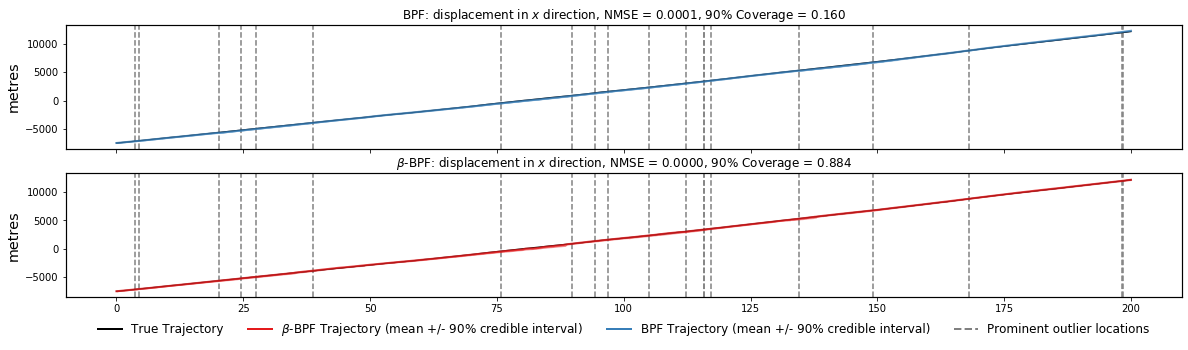

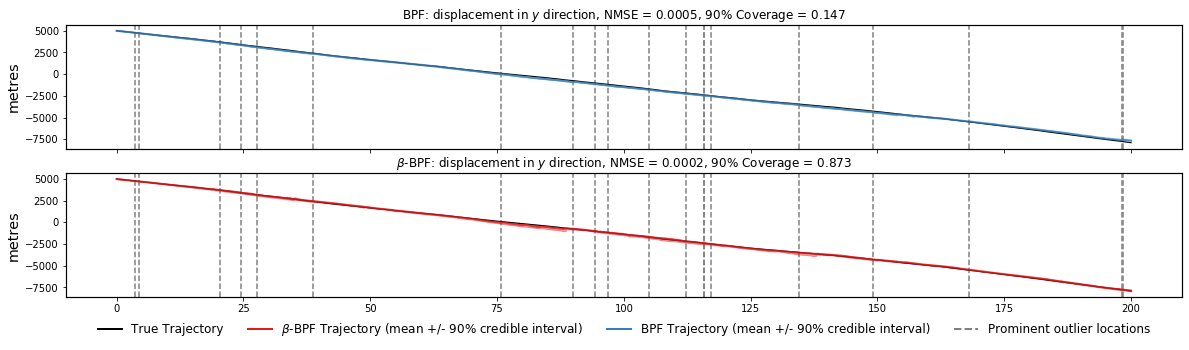

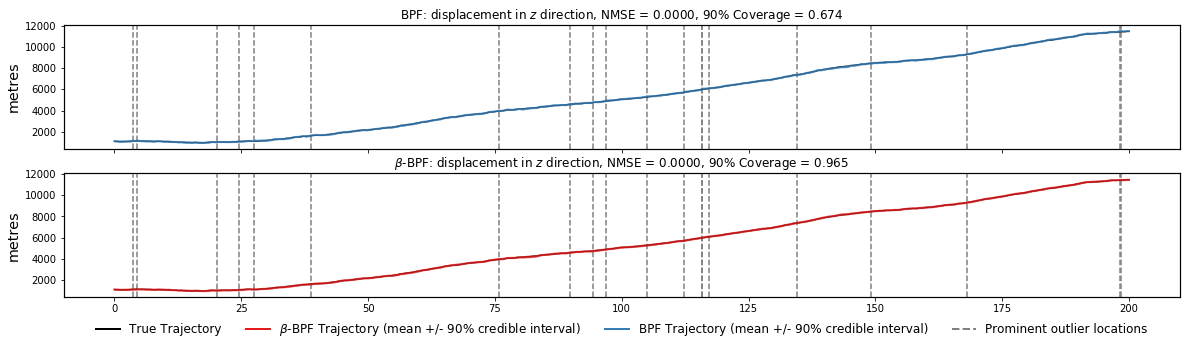

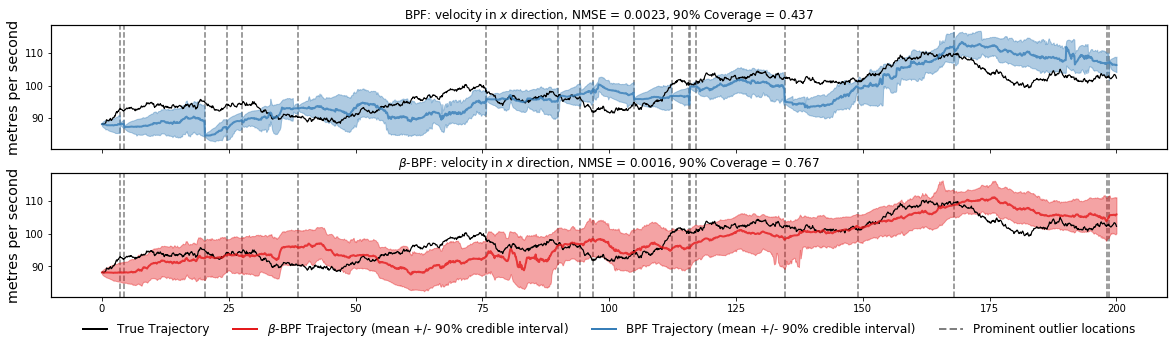

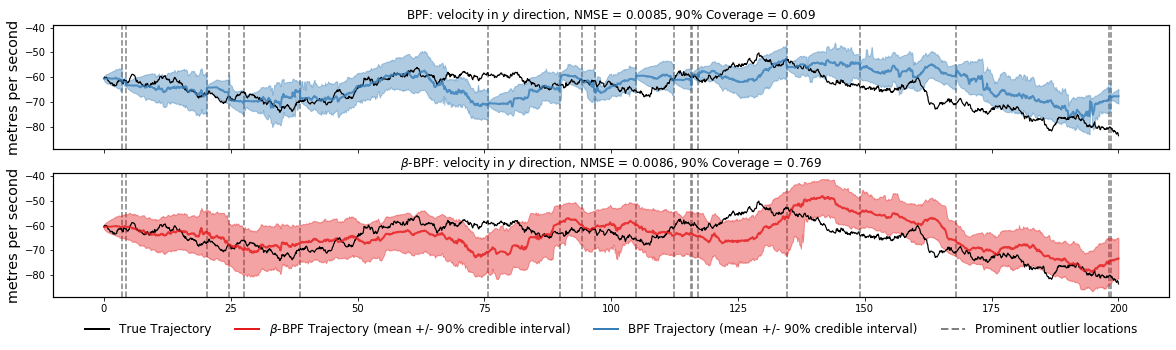

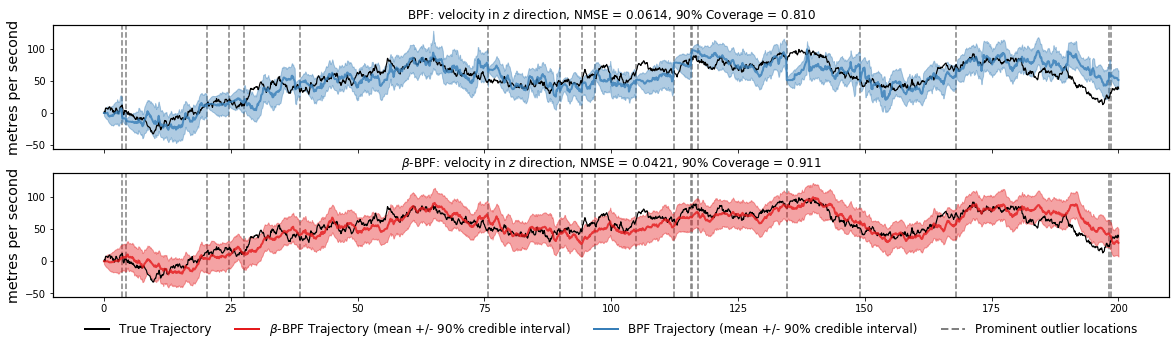

In [14]:
plot_titles = [
    r'displacement in $x$ direction',
    r'displacement in $y$ direction',
    r'displacement in $z$ direction',
    r'velocity in $x$ direction',
    r'velocity in $y$ direction',
    r'velocity in $z$ direction'
]

vanilla_quantiles = np.quantile(vanilla_trajectories, q=[0.05, 0.95], axis=1)
vanilla_mean = np.mean(vanilla_trajectories, axis=1)

robust_quantiles = np.quantile(robust_trajectories, q=[0.05, 0.95], axis=1)
robust_mean = np.mean(robust_trajectories, axis=1)

for var, title in enumerate(plot_titles):
    fig, ax = plt.subplots(nrows=2, figsize=(20, 5), sharey='all', sharex='all')
    ax = ax.flatten()
    plot_trajectories(ax[0], var, vanilla_mean, vanilla_quantiles, 'BPF', title)
    plot_trajectories(ax[1], var, robust_mean, robust_quantiles, r'$\beta$-BPF', title)
    legend_elements = [
        Line2D([0], [0], color='k', label='True Trajectory', markersize=15), 
        Line2D([0], [0], color='C0',  label=r'$\beta$-BPF Trajectory (mean +/- 90% credible interval)', markersize=15),
        Line2D([0], [0], color='C1',  label='BPF Trajectory (mean +/- 90% credible interval)', markersize=15),
        Line2D([0], [0], color='gray',  label='Prominent outlier locations', markersize=15, ls='--')
    ]
    ax[1].legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.42), fontsize='large', frameon=False)
    
    plt.subplots_adjust(hspace=0.2)
    plt.savefig(f'./figures/paper_figures/tan/latent_variable_plots_{var}.pdf', bbox_inches='tight')

## Effective Sample Size

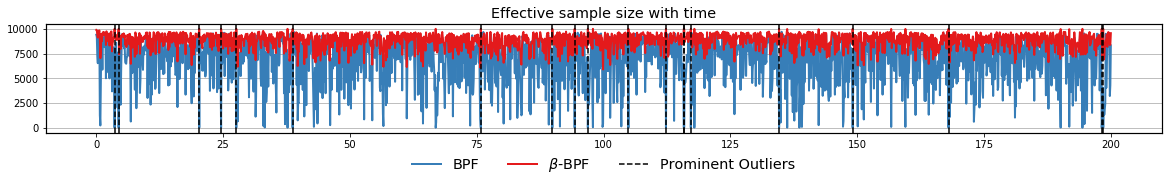

In [19]:
vanilla_ess = [vanilla_bpf.effective_sample_size(logw) for logw in vanilla_bpf.logw]
robust_ess = [robust_bpf.effective_sample_size(logw) for logw in robust_bpf.logw]

plt.figure(figsize=(20, 2))
plt.plot(time_axis, vanilla_ess, label='BPF', c='C1')
plt.plot(time_axis, robust_ess, label=r'$\beta$-BPF', c='C0')
for cl in biggest_outliers[:-1]:
        plt.axvline(time_axis[cl], c='k', ls='--', zorder=10000, linewidth=1.5)
plt.axvline(time_axis[biggest_outliers[-1]], c='k', ls='--', zorder=10000, linewidth=1.5, label='Prominent Outliers')
        
plt.title('Effective sample size with time', fontsize='x-large')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3, fontsize='x-large', frameon=False)
# plt.xlabel('time')
plt.grid(axis='y')
plt.savefig('./figures/paper_figures/tan/effecive_sample_size.pdf', bbox_inches='tight')